# Bayes Theorem

In probability theory and statistics, Bayes' theorem (alternatively Bayes' law or Bayes' rule), named after Reverend Thomas Bayes, describes the probability of an event, based on prior knowledge of conditions that might be related to the event. [1](https://plato.stanford.edu/archives/spr2019/entries/bayes-theorem/)

#### $$P(A|B) = \frac {P(B|A)P(A)}{P(B)}$$

I'm a visual learner. My favourite intuitive example of Bayes Theorem is this [using lego bricks](https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego):

<img src="lego-probability-space.jpeg" width="400" height="400">

The image shows a 60 (6 * 10) lego unit area
 - 40 blue areas
 - 20 red areas
 - 6 intersecting yellow areas. 

We can work through the maths to determine the probabilities and conditional probabilities of each colour.

In [1]:
pBlue = 40/60
pRed = 20/60
pYellow = 6/60
pYellowRed = 4/20 # probabiity of Yellow given Red
pYellowBlue = 2 / 40 # probabiity of Yellow given Blue

print('Cond p(Yellow|Red) = {:.3f}'.format(pYellowRed))
print('Cond p(Yellow|Blue) = {:.3f}'.format(pYellowBlue))

Cond p(Yellow|Red) = 0.200
Cond p(Yellow|Blue) = 0.050


We now some baseline information for the probability and conditional probility of landing on each colour within the Legosphere. We can apply Bayes theorem to generate estimates for "if we land on a yellow brick, what is the probability its red underneath?"

$$P(A|B) = \frac {P(B|A)P(A)}{P(B)}$$

$$P(Red|Yellow) = \frac {P(Yellow|Red)P(Red)}{P(Yellow)}$$

In [2]:
pRedYellow = pYellowRed*pRed/pYellow
print('Cond p(Red|Yellow) = {:.3f}'.format(pRedYellow))

Cond p(Red|Yellow) = 0.667


## Example: Evaluating Insurance claim occurences using Bayesian Inference

Let's recall that Bayesian Inference follows:

 1. Evaluate prior assumptions and observational data. 
 1. Develop a probabilistic model of the data.
 1. Specify prior parameter values for the distributions of the probabilistic model.
 1. Apply Bayes’ theorem to derive the posterior parameter values. 
 
 
###  1. Evaluate prior assumptions and observational data. 
In this example we have sample data for insurance claims occuring by Poisson distributed process. The Poisson distribution is given by:

$$f(y_i|λ)=\frac{e^{−λ}λ^{y_i}}{y_i!}$$

Where lambda λ is the "rate" of events given by the total number of events (k) divided by the number of units (n) in the data (λ = k/n). In the Poisson disribution the expected value E(Y), mean E(X), and variance Var(Y) of Poisson distribution are the same; 

e.g., E(Y) = E(X) = Var(X) = λ. 

**note** that if the variance is greater than the mean, the data is said to be overdispersed. This is common in insurance claim data with lots of zeros and is better handled by the NegativeBinomial and [zero-inflated models](https://stats.idre.ucla.edu/r/dae/zip/) such as ZIP and ZINB.

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Mean=2.17, Var=1.99


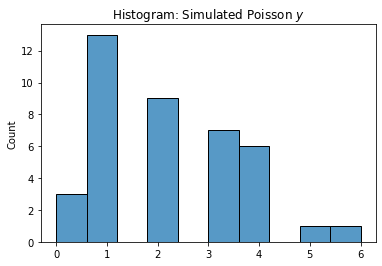

In [4]:
n = 40
lam_ = 2
y = np.random.poisson(lam=lam_,size=n)

print("Mean={:.2f}, Var={:.2f}".format(np.mean(y),np.var(y)))

sns.histplot(y,bins=10)
plt.title('Histogram: Simulated Poisson $y$');

The right-skew "heavy tail" in our observational data fits a gamma-poisson model. This is termed the gamma-poisson conjugate prior. We could also use a beta-poisson, or any distribution that resembles the data, but gamma-poisson is suitable as [Hyvönen & Tolonen 2019](https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html): 
- poisson can take on any positive number to infinity(0,∞), whereas a beta or uniform is [0-100]. 
- gamma has a peak close to zero
- gamma tail goes to infinity.

The gamma-poisson prior is then:

$$λ∼Γ(a,b)$$

Where a and b are the gamm shape and scale (or rate when 1/scale)  of the gamma-poisson distribution. The gamma density functions is:

$$f(λ)=\frac{b^a}{Γ(a)}λ^{a−1}e^{−bλ}$$

where a>0 is the shape parameter,and b>0 is the rate parameter, and 

$E(λ)=\frac{a}{b}$ and $Var(λ)=\frac{a}{b^2}$

In [5]:
# estimate gamma params
# shape, loc, scale
# stats.gamma.fit(y)

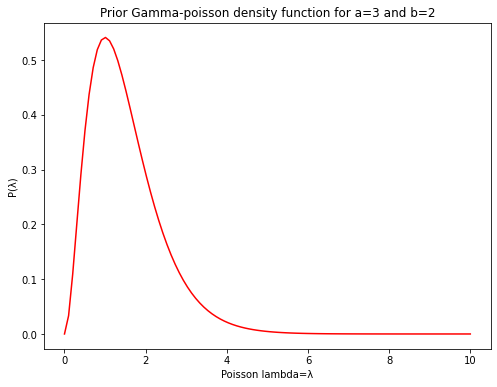

In [6]:
# Parameters of the prior gamma distribution.
a = 3 # shape
b = 2 #stats.gamma.fit(y) rate = 1/scale
x = np.linspace(start=0, stop=10, num=100) # options for lambda

# Define the prior distribution.
prior = lambda x: stats.gamma.pdf(x, a=a, scale=1/b)
priors = prior(x)

# plot
plt.figure(figsize=(8, 6))
plt.plot(x, priors, 'r-')
plt.title('Prior Gamma-poisson density function for a={} and b={}'.format(a,b))
plt.xlabel('Poisson lambda=λ')
plt.ylabel('P(λ)');

### likelihood function

The gamma function is often referred to as the generalized factorial since:

Γ(n+1) = n!

then the likelihood function is:


$$f(y|λ)=\prod_{i=1}^{n}\frac{e^{−λ}λ^{λ_i}}{y_i!} = \frac{e^{-nλ}λ\sum_{i=1}^{n}y_i}{\prod_{i=1}^{n}y_i!}$$

In [7]:
import math
import scipy.special as sp

# generalised gamma == factorial
n = 3
sp.gamma(n+1) == math.factorial(n)

True

In [8]:
# likelihood function
def likelihood(lam,y):
    """ Gamma-poisson likelihood function"""
    
    factorials = np.apply_along_axis(
                    func1d=lambda Yi: sp.gamma(Yi+1),
                    axis=0,
                    arr=y)
    
    # exponential (-lambda*n) * (lambda**sum(y))
    numerator = np.exp(-lam*y.size)*(lam**y.sum())
    
    # product of gamma (aka factorial) of y
    denominator = np.multiply.reduce(factorials)
    
    # likelihoods, remove zeros
    l = np.array(numerator/denominator)
    l[np.isnan(l)] = 0.0
    return l

In [9]:
# Define the posterior distribution.
def posterior_up_to_constant(lam,y):
    return likelihood(lam,y)*prior(lam)

# calculate posteriors and normalise
Cposteriors =  posterior_up_to_constant(x,y)
Cposteriors = Cposteriors/Cposteriors.sum()

then as
$$f(λ|y)∝λ^(\sum_{i=1}^{n}y_i+a)^{−1}e^{−(n+b)λ}$$ 
the posterior distribution is again a gamma

$$f(λ|y)=Γ\big(\sum_{i=1}^{n}y_i+a,n+b\big)$$

In [10]:
def posterior(lam,y):
    
    shape = a + y.sum()
    rate = b + y.size
    
    return stats.gamma.pdf(lam, shape, scale=1/rate)

posterior = posterior(x,y)

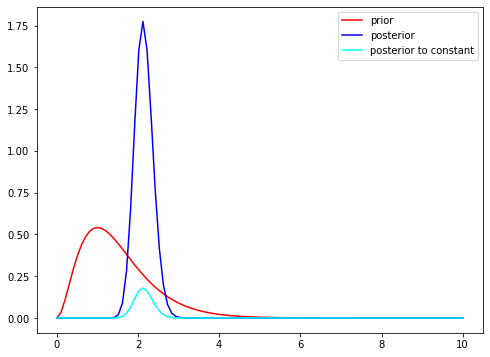

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(x, priors, 'r-', label='prior')
plt.plot(x, posterior,c='blue', label='posterior')
plt.plot(x, Cposteriors,c='cyan', label='posterior to constant')
plt.legend();

As shown the the posterior mean (blue) is centered around the true lambda rate that we set at the start. The posterio mean is:

$$\frac{\sum_{i=1}^{n}y_i+a}{n+b}$$

i.e. the posterior mean is a weighted average of the prior mean and the observed sample average $\bar{y}$

In [12]:
print(f"""True lambda: {lam_}
prior mean: {a/b}
posterior mean: {(a+y.sum()) / (b+y.size)}
sample mean:{y.mean()}""")


True lambda: 2
prior mean: 1.5
posterior mean: 2.142857142857143
sample mean:2.175


## Markov-Chain-Monte-Carlo (MCMC)
### [PyMC3](https://pymc3-testing.readthedocs.io/en/rtd-docs/api.html)

Now lets re-produce the steps above in PyMC3. 

In [13]:
import pymc3 as pm

In [14]:
# known initial params
a,b,lam_,y.shape

(3, 2, 2, (40,))

In [15]:
model = pm.Model()

with model:
    
    # Define the prior of the parameter lambda.
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=lam_, observed=y)
    
    # Consider 2000 draws and 3 chains.
    trace = pm.sample(draws=2000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [lambda]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:06<00:00, 1235.13draws/s]


The above configuration simulates the posterior distribution for 3 independent Markov-Chains (traces). The traceplots display the results for each simulation. 

Below the mean, quantile, credible interval (HPD) 94%, and arbitary reference value (orange vertical).

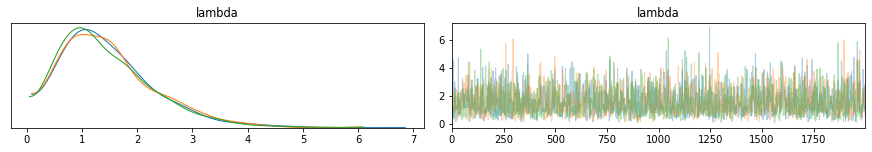

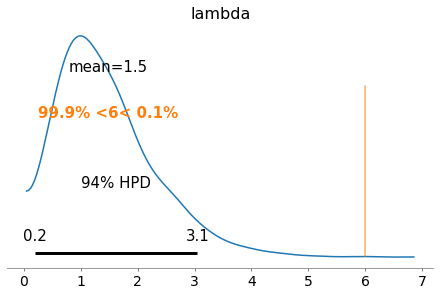

In [16]:
# note there are a few user warnings on using pymc3.traceplot() with pyplot
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)
    pm.plot_posterior(trace,ref_val=6);

### references
- https://www.sciencedirect.com/science/article/abs/pii/S0740002005000249
- https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html